# Structure Data for BPNN

In [7]:
from Dataset import *
import cupy as cp
from bpnn_cuda import BPNN
from tqdm.notebook import tqdm

def convert_categories(y_cat):
    desired = cp.array([0 if y[0] == 1 else 1 for y in y_cat])
    return desired

def get_data():
    d = Dataset.load_gzip(os.path.join(
        "datasets", "face_mask_pickled"), "dataset_gray_conv_test_2.pkl.gzip")

    ndimen = d.train.X.shape[1]

    # Structure Training Data for BPNN
    training_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.train.X]
    training_results = [cp.asarray(y.reshape(-1, 1)) for y in d.train.y]

    training_data = zip(training_inputs, training_results)
    # Structure Validation Data for BPNN
    validation_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.validation.X]
    validation_data = zip(validation_inputs, convert_categories(d.validation.y))
    # Structure Testing Data for BPNN
    testing_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.test.X]
    testing_data = zip(testing_inputs, convert_categories(d.test.y))

    return training_data, validation_data, testing_data, ndimen


training_data, validation_data, testing_data, ndimen = get_data()
print(f"Input Dimension: {ndimen}")

ntrials = 5
max_epochs = 15
init_nc = [ndimen, 200, 2]
init_b = 40
init_lr = 0.5

Input Dimension: 900


# Train Initial BPNN Configuration

In [8]:

model_BPNN = BPNN(init_nc, verbose=True)
final_score, eval_scores, eval_scores_deltas, conv_time = model_BPNN.train(training_data,
                                                                           max_epochs=max_epochs,
                                                                           batch_size=init_b,
                                                                           learning_rate=init_lr,
                                                                           evaluation_data=validation_data)


# Training MLP Network: Sizes=[900, 200, 2]	Epochs=15	Batch-Size=40	Learning-Rate=0.5
 - Training Data Len: 10000
 - Validation Data Len: 800
# Epochs:


  0%|          | 0/15 [00:00<?, ?it/s]

	1. Correct 689/800	(score: 0.86125	delta: 0.86125	delta_avg: 0.86125)
	2. Correct 721/800	(score: 0.90125	delta: 0.040000000000000036	delta_avg: 0.450625)
	3. Correct 727/800	(score: 0.90875	delta: 0.007499999999999951	delta_avg: 0.30291666666666667)
	4. Correct 732/800	(score: 0.915	delta: 0.006250000000000089	delta_avg: 0.22875)
	5. Correct 733/800	(score: 0.91625	delta: 0.0012499999999999734	delta_avg: 0.18325)
	6. Correct 737/800	(score: 0.92125	delta: 0.0050000000000000044	delta_avg: 0.15354166666666666)
	7. Correct 734/800	(score: 0.9175	delta: -0.003750000000000031	delta_avg: 0.13107142857142856)
	8. Correct 735/800	(score: 0.91875	delta: 0.0012499999999999734	delta_avg: 0.11484375)
	9. Correct 736/800	(score: 0.92	delta: 0.0012500000000000844	delta_avg: 0.10222222222222223)
	10. Correct 738/800	(score: 0.9225	delta: 0.0024999999999999467	delta_avg: 0.09225)
	11. Correct 736/800	(score: 0.92	delta: -0.0024999999999999467	delta_avg: 0.08363636363636363)
	12. Correct 736/800	(sco

# Tune Network Configuration

Training Epoch vs. Accuracy (Effect of Network Configuration)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[900, 50, 2] => 0.9125


  0%|          | 0/15 [00:00<?, ?it/s]

[900, 100, 2] => 0.925


  0%|          | 0/15 [00:00<?, ?it/s]

[900, 200, 2] => 0.925


  0%|          | 0/15 [00:00<?, ?it/s]

[900, 400, 2] => 0.91875


  0%|          | 0/15 [00:00<?, ?it/s]

[900, 800, 2] => 0.905


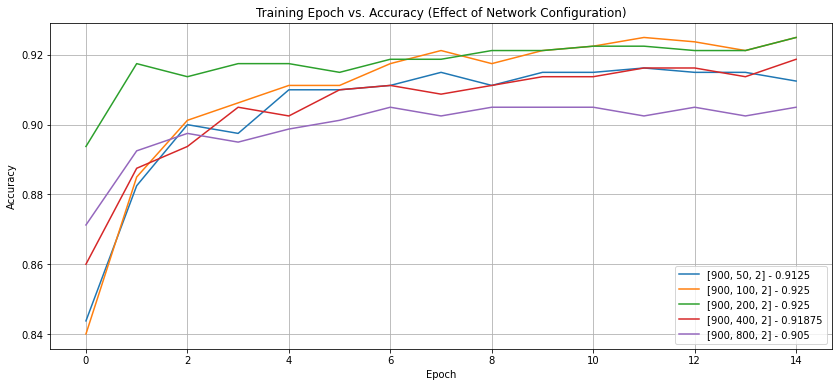

Best network configuration: [900, 100, 2]


In [9]:
def plot_accuracies_hidden_layers_and_nodes(save_dir, layers_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Network Configuration)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(
        f"Training Epoch vs. Accuracy (Effect of Network Configuration)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for layers in tqdm(layers_arr):
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(layers, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=init_b,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{layers} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = layers
        plt.plot(epoch_scores, label=f'{layers} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_layers_vs_acc', dpi=100)

    return best_config


layers_arr = [[ndimen, 50, 2],
              [ndimen, 100, 2],
              [ndimen, 200, 2],
              [ndimen, 400, 2],
              [ndimen, 800, 2],
              
              [ndimen, 75, 2],
              [ndimen, 90, 2],
              [ndimen, 110, 2],
              [ndimen, 130, 2],
              [ndimen, 160, 2],
              [ndimen, 190, 2], ]


best_nc = plot_accuracies_hidden_layers_and_nodes("img", layers_arr)
print(f"Best network configuration: {best_nc}")


# Tune Batch Size

Training Epoch vs. Accuracy (Effect of Batch Size)


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

20 => 0.92875


  0%|          | 0/15 [00:00<?, ?it/s]

30 => 0.91875


  0%|          | 0/15 [00:00<?, ?it/s]

35 => 0.925


  0%|          | 0/15 [00:00<?, ?it/s]

40 => 0.92125


  0%|          | 0/15 [00:00<?, ?it/s]

45 => 0.92375


  0%|          | 0/15 [00:00<?, ?it/s]

50 => 0.925


  0%|          | 0/15 [00:00<?, ?it/s]

60 => 0.91625


  0%|          | 0/15 [00:00<?, ?it/s]

70 => 0.9225


  0%|          | 0/15 [00:00<?, ?it/s]

80 => 0.91125


  0%|          | 0/15 [00:00<?, ?it/s]

90 => 0.91125


  0%|          | 0/15 [00:00<?, ?it/s]

100 => 0.90375


  0%|          | 0/15 [00:00<?, ?it/s]

110 => 0.915


  0%|          | 0/15 [00:00<?, ?it/s]

120 => 0.91875


  0%|          | 0/15 [00:00<?, ?it/s]

130 => 0.91125


  0%|          | 0/15 [00:00<?, ?it/s]

140 => 0.90625


  0%|          | 0/15 [00:00<?, ?it/s]

150 => 0.90625


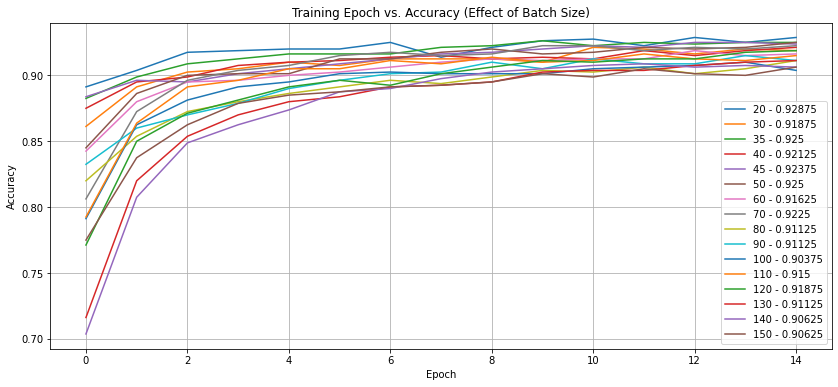

Best batch size: 20


In [10]:
def plot_accuracies_mini_batch_size(save_dir, batch_size_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Batch Size)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Batch Size)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for batch_size in tqdm(batch_size_arr):
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=batch_size,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{batch_size} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = batch_size
        plt.plot(epoch_scores, label=f'{batch_size} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_batch_vs_acc', dpi=100)

    return best_config


batch_size_arr = [5, 8, 12, 14, 16, 18, 20, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
best_b = plot_accuracies_mini_batch_size("img", batch_size_arr)
print(f"Best batch size: {best_b}")

# Tune Learning Rate

Training Epoch vs. Accuracy (Effect of Learning Rate)
Training Epoch vs. Accuracy (Effect of Learning Rate)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0.75 => 0.91875


  0%|          | 0/15 [00:00<?, ?it/s]

0.65 => 0.92


  0%|          | 0/15 [00:00<?, ?it/s]

0.6 => 0.93


  0%|          | 0/15 [00:00<?, ?it/s]

0.55 => 0.9275


  0%|          | 0/15 [00:00<?, ?it/s]

0.5 => 0.92375


  0%|          | 0/15 [00:00<?, ?it/s]

0.45 => 0.9325


  0%|          | 0/15 [00:00<?, ?it/s]

0.4 => 0.925


  0%|          | 0/15 [00:00<?, ?it/s]

0.35 => 0.91125


  0%|          | 0/15 [00:00<?, ?it/s]

0.25 => 0.93


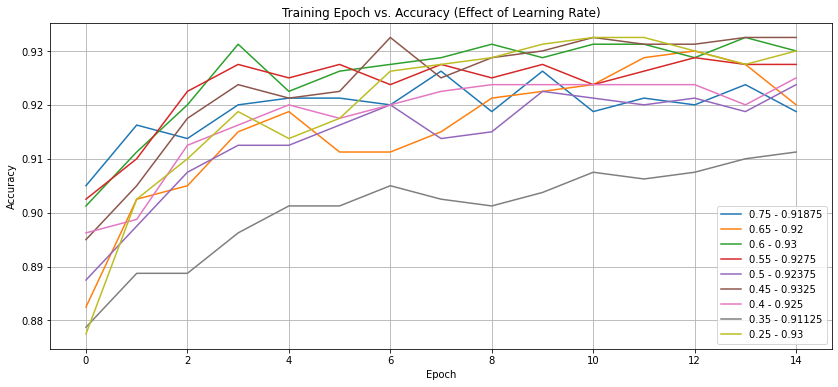

Best learning rate: 0.45


In [11]:
def plot_accuracies_learning_rate(save_dir, learning_rate_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for learning_rate in tqdm(learning_rate_arr):
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=best_b,
                                                                               learning_rate=learning_rate,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)

            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{learning_rate} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = learning_rate

        plt.plot(epoch_scores, label=f'{learning_rate} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_lr_vs_acc', dpi=100)

    return best_config


learning_rate_arr = [0.75, 0.65, 0.60, 0.55, 0.5, 0.45, 0.40, 0.35, 0.25, 0.15, 0.1, 0.05, 0.01, 0.005, 0.001]
best_lr = plot_accuracies_learning_rate("img", learning_rate_arr)
print(f"Best learning rate: {best_lr}")

# Train Best Model

In [21]:
"""
Plot the convergence curve of BPNN
"""

training_data, validation_data, testing_data, ndimen = get_data()

print('# Best Hyperparameters:')
print(f' - Best Network Configuration: {best_nc}')
print(f' - Best Batch Size: {best_b}')
print(f' - Best Learning Rate: {best_lr}')


nn = BPNN(best_nc)
final_score, eval_scores, eval_scores_deltas, nn_conv_time = nn.train(training_data,
                                                                      max_epochs=max_epochs,
                                                                      batch_size=best_b,
                                                                      learning_rate=best_lr,
                                                                      evaluation_data=validation_data,
                                                                      evaluation_treshold=None)




# Best Hyperparameters:
 - Best Network Configuration: [900, 100, 2]
 - Best Batch Size: 20
 - Best Learning Rate: 0.45


  0%|          | 0/15 [00:00<?, ?it/s]

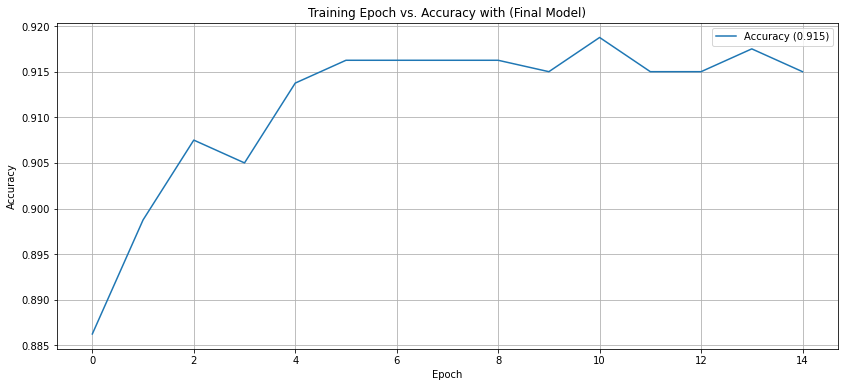

In [26]:
fig = plt.figure(figsize=(14, 6))

plt.title(f"Training Epoch vs. Accuracy with (Final Model)")
plt.xlabel("Epoch")
plt.ylabel('Accuracy')

plt.plot(eval_scores, label=f'Accuracy ({final_score})')

plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_best_model', dpi=100)

# Save Best Model & Predictions

In [16]:
import gzip

# make directory to save generated images to
os.makedirs('models', exist_ok=True)

def save_best_model():
    # Save the best BPNN model to a pickle file
    with gzip.open('models/bpnn_best_model.pkl.gzip', 'wb') as f:
        pickle.dump(nn, f)
    
def save_testing_pred(data):
    # Tuples (X, y, y_pred)
    
    new_data = []
    for (x, y) in data:
        decision = np.argmax(nn.feedforward(x))
        new_data.append((x, y, decision))
        
    with gzip.open('models/bpnn_testing_pred.pkl.gzip', 'wb') as f:
        pickle.dump(new_data, f)


training_data, validation_data, testing_data, ndimen = get_data()
save_best_model()
save_testing_pred(testing_data)


# Load the Model

In [22]:
# Load the best model from file
with gzip.open('models/bpnn_best_model.pkl.gzip', 'rb') as f:
    nn = pickle.load(f)

# Evaluate Model

In [24]:
def evaluate(dataset, name):

    acc = 0
    acc0 = 0
    len0 = 0
    acc1 = 0
    len1 = 0

    for (x, y) in dataset:
        decision = np.argmax(nn.feedforward(x))

        if decision == y:
            acc += 1
        if y == 0:
            len0 += 1
            if decision == y:
                acc0 += 1
        if y == 1:
            len1 += 1
            if decision == y:
                acc1 += 1

    nn_acc = acc / (len0 + len1)
    # Compute class accuracies
    nn_acc0 = acc0 / len0
    nn_acc1 = acc1 / len1

    print(f'Overall {name} Accuracy: {nn_acc}')
    print(f'Class 0 {name} Accuracy: {nn_acc0}')
    print(f'Class 1 {name} Accuracy: {nn_acc1}')
    
    return nn_acc, nn_acc0, nn_acc1


training_data, validation_data, testing_data, ndimen = get_data()


vnn_acc, vnn_acc0, vnn_acc1 = evaluate(validation_data, "Validation")
print()
tnn_acc, tnn_acc0, tnn_acc1 = evaluate(testing_data, "Testing")



Overall Validation Accuracy: 0.91625
Class 0 Validation Accuracy: 0.8925
Class 1 Validation Accuracy: 0.94

Overall Testing Accuracy: 0.9183467741935484
Class 0 Testing Accuracy: 0.9155206286836935
Class 1 Testing Accuracy: 0.9213250517598344


# Plot Bar Chart

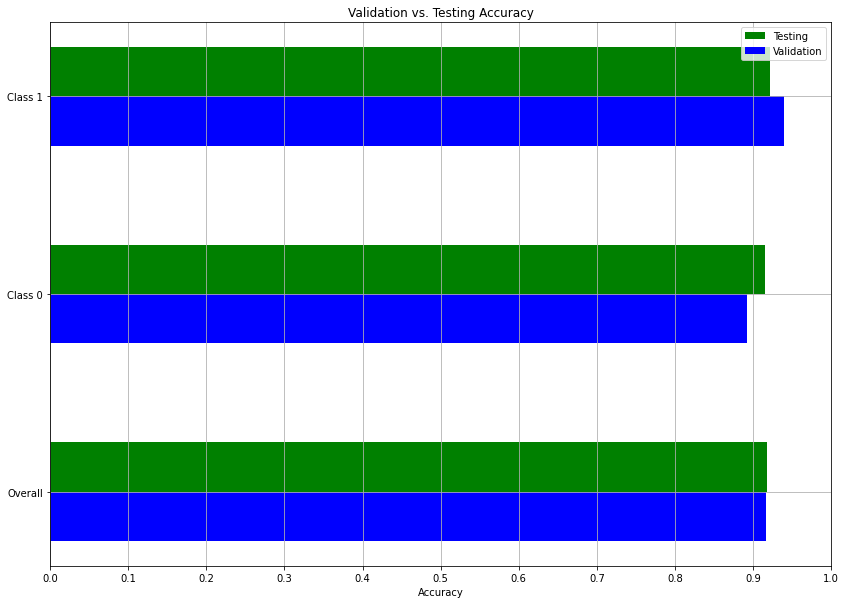

In [25]:
# Plot a barchart comparing the validation vs testing accuracies overall, for class 0, and for class 1 side by side

# set the y axis major ticks to .1 and minor ticks to .01
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.01)



fig = plt.figure(figsize=(14, 10))

plt.title(f"Validation vs. Testing Accuracy")
plt.xlabel("Accuracy")

width = 0.25
plt.barh(0 + width/2, tnn_acc, width, label='Testing', color='green')
plt.barh(0 - width/2, vnn_acc, width, label='Validation', color='blue')

plt.barh(1 + width/2, tnn_acc0, width, color='green')
plt.barh(1 - width/2, vnn_acc0, width, color='blue')

plt.barh(2 + width/2, tnn_acc1, width, color='green')
plt.barh(2 - width/2, vnn_acc1, width, color='blue')

plt.yticks(np.arange(0, 3, 1), ['Overall', 'Class 0', 'Class 1'])
plt.xticks(major_ticks)
plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_validation_vs_testing', dpi=100)


# Use Pygame to Capture Screenshot and Test

In [29]:

import pygame
import pygame.camera
from PreProcessing import PreProcessing
from convolution import *

pygame.camera.init()
pygame.camera.list_cameras() #Camera detected or not
cam = pygame.camera.Camera("/dev/video0",(200,200))
cam.start()
img = cam.get_image()
pygame.image.save(img,"cam.jpg")




def t_resize(X):
    # resize training data
    return PreProcessing.resize_images(X, size=(128, 128, 3))

def t_grayscale(X):
    return PreProcessing.dataset2grayscale(X)


def t_scale(X):
    return PreProcessing.min_max_scale_dataset(X)


def get_cnn_gray(flatten: bool):
    # convolution kernel
    kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])  # sharper images

    k_sharpen = np.array(
        [[0, -1, 0], [-1, 10, -1], [0, -1, 0]])  # sharper images

    k_outline = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])  # outline
    k_emboss = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])  # emboss

    k_blur = np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]])  # gaussian blur

    k_test = np.array([[-1, -1, -1],
                       [-1, 100, -1],
                       [-1, -1, -1]])

    k_test1 = np.array([[-1, -1, -1],
                       [1.15, 1.15, 1.15],
                       [-1, -1, -1]])

    k_test2 = np.array([[-1, 1.15, -1],
                       [-1, 1.15, -1],
                       [-1, 1.15, -1]])

    k_test3 = np.array([[-1, -1, 1.15],
                       [-1, 1.15, -1],
                       [1.15, -1, -1]])

    k_test4 = np.array([[1.15, -1, -1],
                       [-1, 1.15, -1],
                       [-1, -1, 1.15]])

    k_test_app = []

    k_test_app.append(k_test1)
    k_test_app.append(k_test2)
    k_test_app.append(k_test3)
    k_test_app.append(k_test4)

    k_test_app = np.array(k_test_app)
    print(k_test_app.shape)

    # build model
    model = Sequential()

    model.add(Conv(kernel=k_test1, name="input_layer"))
    model.add(Pooling2D(mode='max'))
    
    model.add(Conv(kernel=k_outline, name="input_layer"))
    model.add(Activation('relu'))

    model.add(Pooling2D(mode='max'))

    if (flatten):
        model.add(Flatten())
        
    model.summary()
    return model




img = t_resize(img)
img = t_grayscale(img)
img = t_scale(img)

# display original image
plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.show()

# feed image through model
x_flat = get_cnn_gray(flatten=True).feedforward(img)
x = get_cnn_gray(flatten=False).feedforward(img)

# display original image
plt.figure(figsize=(10, 10))
plt.title("Convoluted Image")
plt.imshow(x, cmap='gray')
plt.show()

def vectorize():
    cp.reshape(cp.asarray(x), (ndimen, 1))
    
print(np.argmax(nn.feedforward()))


ModuleNotFoundError: No module named 'pygame'